In [1]:
import keras
import innvestigate
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sb
import cartopy.crs as ccrs
import cartopy
import xarray as xr
from cartopy.util import add_cyclic_point as acp
from matplotlib.colors import ListedColormap
from copy import deepcopy
from sklearn.cluster import KMeans
cm = ListedColormap(sb.color_palette("seismic", 160)[80:])
sb.set_style('white')

Using TensorFlow backend.
/Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Jamin/anaconda3/env

In [2]:
# Makes these global for potential editing within scripts
VAR = sorted(['tas']) # the variables used for the ANN, always alphabetical
PRIM = 'cmip6' #primary dataset for model training and validation
OBS = {'tas':'BEST','pr':'ERA5'} #observational dataset for model testing, dictionary from each VAR
TIMETYPE = 'annual' #are we using just 'annual' mean data? Means each 'season'? Means each 'month'?
TIMERANGE = ['1920','2099']
RES = 'r90x45' # the resolution of the data, format: r90x45
REGION = 'globe-land' # Define region in get_region_bounds, None is global

# Computer username
USER = 'Jamin'
USER = 'jrader'

ROOT = '/Users/' + USER + '/Rams/TOE_Research/' # root directory for the whole project
PATH = ROOT + 'data/' # the path of the netCDF files (before PRIM)
STAND_TYPE = 'classification/'
SAVE_LRP_PATH = PATH + 'lrp_npz_' + RES + '/' + STAND_TYPE
MODEL_DIR = 'models/' + STAND_TYPE
PLOT_DIR = 'plots/' + STAND_TYPE + 'lrp/'
MASK = PATH + 'landmask/landmask_nopole_' + RES + '.npz'

MODEL_NUM = 1 # only used if loading a previously saved model

VAL_SPLIT = .2 # what fraction of the models should be used for validation?
VAL_MODELS = [16, 9 ,8, 1] #None #[10,  3, 12, 24,  5, 21] # number of the models to be held from training
REMOVE_GLOBAL_MEAN = False

In [3]:
def load_model(update_globals=True, filename = None):
    # update_global updates the global variables above to fit the data the model was trained on
    if filename:
        #model = keras.models.load_model(ROOT + MODEL_DIR + filename)
        model = keras.models.load_model(filename)
        return model
    else:
        model = keras.models.load_model(ROOT + MODEL_DIR + 'model.%03d.h5' % MODEL_NUM, compile=False)
        f = open(ROOT + MODEL_DIR + 'modelspecs.%03d.p' % MODEL_NUM,'rb')
        specs = pickle.load(f)
        f.close()
    if update_globals:
        global VAR, PRIM, OBS, TIMETYPE, TIMERANGE, RES, REGION, VAL_MODELS, REMOVE_GLOBAL_MEAN
        VAR = specs['dataset info']['variables']
        PRIM = specs['dataset info']['training dataset']
        TIMETYPE = specs['dataset info']['timetype']
        TIMERANGE = specs['dataset info']['timerange']
        RES = specs['dataset info']['resolution']
        REGION = specs['dataset info']['region']
        REMOVE_GLOBAL_MEAN = specs['dataset info']['global mean remove']
        VAL_MODELS = specs['dataset info']['validation model id numbers']
    return model, specs

#####
### Region mask
#####

def unmask(data, lats, lons, fill = np.nan):
    # incoming data should be one-dimensional 
    maskinfo = np.load(MASK) # boolland has shape lats, lons
    boolland, boollats, boollons = maskinfo['mask'], maskinfo['lats'], maskinfo['lons']
    # Shaping to the domain of the input data
    boolland = boolland[np.logical_and(boollats >= np.min(lats), boollats <= np.max(lats)), :]
    boolland = boolland[:,np.logical_and(boollons >= np.min(lons), boollons <= np.max(lons))]
    output_lons = boollons[np.logical_and(boollons >= np.min(lons), boollons <= np.max(lons))]
    output_lats = boollats[np.logical_and(boollats >= np.min(lats), boollats <= np.max(lats))]    
    
    # Putting the good data into a new matrix, fill the remaining space with filltype (default: np.nan)
    output_data = np.full(boolland.shape, fill)
    output_data[boolland] = data.copy()
    
    return output_data, output_lats, output_lons
    
    

#####
### INNvestigate
#####

def innvestigation(model, lrp_data):
    
    biasBool = False # Predicted year won't be the same if set to True
    #analyzer = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model, bias=biasBool)
    analyzer = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlphaBeta(model, alpha=1, beta=0, 
                                                                                     bias=biasBool)
    lrp_outputraw = analyzer.analyze(lrp_data) # Analyze model behavior on all testing and training data
    return lrp_outputraw

def return_fractional_relevance(model, lrp_data):
    
    lrp_outputraw = innvestigation(model, lrp_data)
    lrp_output = (lrp_outputraw / np.nansum(lrp_outputraw, axis=1).reshape(-1,1)) #look at this, make sure it's right
    lrp_output = lrp_output.reshape( -1, len(VAR), len(lats) * len(lons) )
    lrp_output = np.sum(lrp_output, axis=-1)
    
    # Return mean, 10th, 90th percentile 
    return np.mean(lrp_output, axis=0), np.quantile(lrp_output, .10, axis=0), np.quantile(lrp_output, .90, axis=0)

def LRP(model, lrp_data, lats, lons, timemean = True):
    lrp_outputraw = innvestigation(model, lrp_data)
    lrp_output = (lrp_outputraw / np.nansum(lrp_outputraw, axis=1).reshape(-1,1)) #divide by sum of year
    #lrp_output = lrp_outputraw.copy()
    #lrp_output[lrp_output < 0] = 0 # zero out negative relevances for LRPepsilon
    if timemean:
        lrp_output = np.nanmean(lrp_output, axis=0) # take the mean of responses across model years
        lrp_output = np.reshape(lrp_output, (len(VAR), -1)) # -1 basically is lats and lons
    
    #lrp_output = np.reshape(lrp_output, (len(VAR), len(lats), len(lons)))

    return lrp_output

def normLRP(lrp_output, normtype = None):
    print('Normalization: ' + str(normtype))
    if normtype == 'individual':
        lrp_output = (lrp_output.T / np.max(lrp_output, axis=(-1))).T # normalizing each map
    elif normtype == 'overall':
        lrp_output = (lrp_output.T / np.max(lrp_output)).T # normalizing over all maps
    else:
        print('No Normalization')
    return lrp_output

        
def plot(lrp_output, lats, lons, identifier, titles = None, ncols=4, zoom=False, 
         saveplot=False, savedata=False):
    # lrp_output has shape YEARS x VAR x (latxlon, masked)
    totalmaps = lrp_output.shape[0]
    
    if ncols > totalmaps:
        print('Too many columns, switching ncols to 1')
        ncols = 1
    
    nrows = totalmaps // ncols
    
    ax = dict()
    
    projection = ccrs.Robinson()

    if not zoom:
        fig, axs = plt.subplots(nrows, ncols, figsize=(1 + 4*ncols, 1 + 4*nrows),
                           subplot_kw={'projection': projection})
    
    else:
        fig, axs = plt.subplots(nrows*ncols, 1, figsize=(12, 1 + 5*nrows*ncols),
                           subplot_kw={'projection': projection})
    
    axs =np.array(axs)

    for k, ax in enumerate(axs.flatten()):
        print(k, end = ' ')
        lrp_plot, lats, lons = unmask(lrp_output[k], lats, lons)
        data, cyc_lons = acp(lrp_plot, lons)
        pcm = ax.pcolormesh(cyc_lons, lats, data, transform=ccrs.PlateCarree(), cmap=cm, 
                         vmax = np.nanmax(lrp_output), vmin = 0, zorder=2)
        ax.coastlines(zorder=3)
        #ax[k].add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='0')
        if titles:
            print(titles[k])
            ax.set_title(titles[k])
        if savedata:
            datasavename = ROOT + PLOT_DIR + 'npzdata/lrp_' + '_'.join(titles[k].split(' ')) + '.npz'
            np.savez(datasavename, lons=cyc_lons, lats=lats, lrp=data)
    plt.suptitle(identifier,size=20)
    plt.subplots_adjust(wspace=.04, hspace=.12)
    fig.colorbar(pcm, ax = axs, location='right', shrink=0.8)
    
    if saveplot:
        plotsavename = ROOT + PLOT_DIR + 'lrp_' + identifier + '.png'
        plt.savefig(plotsavename, dpi=300, bboxes_inches='tight', pad=.05)
        
def plot_diff(lrp_output1, lrp_output2, lats, lons, identifier, titles = None, ncols=4, zoom=False,
              saveplot=False, savedata=False):
    # lrp_output has shape YEARS x VAR x (latxlon, masked)
    lrp_output = lrp_output1 - lrp_output2
    totalmaps = lrp_output.shape[0]
    
    if ncols > totalmaps:
        print('Too many columns, switching ncols to 1')
        ncols = 1
    
    nrows = totalmaps // ncols
    
    ax = dict()
    
    projection = ccrs.Robinson()
    
    if not zoom:
        fig, axs = plt.subplots(nrows, ncols, figsize=(1 + 4*ncols, 1 + 4*nrows),
                           subplot_kw={'projection': projection})
    
    else:
        fig, axs = plt.subplots(nrows*ncols, 1, figsize=(12, 1 + 5*nrows*ncols),
                           subplot_kw={'projection': projection})
    
    axs =np.array(axs)

    for k, ax in enumerate(axs.flatten()):
        print(k, end = ' ')
        lrp_plot, lats, lons = unmask(lrp_output[k], lats, lons)
        data, cyc_lons = acp(lrp_plot, lons)
        pcm = ax.pcolormesh(cyc_lons, lats, data, transform=ccrs.PlateCarree(), cmap='bwr', 
                         vmax = np.nanmax(np.abs(lrp_output)), vmin = -np.nanmax(np.abs(lrp_output)), zorder=2)
        ax.coastlines(zorder=3)
        #ax[k].add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='0')
        if titles:
            print(titles[k])
            ax.set_title(titles[k])
        #if savedata:
            #datasavename = ROOT + PLOT_DIR + 'npzdata/lrp_' + '_'.join(titles[k].split(' ')) + '.npz'
            #np.savez(datasavename, lons=cyc_lons, lats=lats, lrp=data)
    plt.suptitle(identifier,size=20)
    plt.subplots_adjust(wspace=.04, hspace=.12)
    fig.colorbar(pcm, ax = axs, location='right', shrink=0.8)
    
    #if saveplot:
        #plotsavename = ROOT + PLOT_DIR + 'lrp_' + identifier + '.png'
        #plt.savefig(plotsavename, dpi=300, bboxes_inches='tight', pad=.05)
    
### This is good for a very quick look at one model, but otherwise outdated. 
def plot_LRP_maps(model, lrp_data, lats, lons, identifier, specs_dict = '', title=None, norm='no'):

    lrp_output = normLRP(LRP(model, lrp_data, lats, lons), normtype = 'overall')

    for iplot in range(np.shape(lrp_output)[0] + int(np.shape(lrp_output)[0] > 1)):
        plt.figure(figsize=(12,5))
        #plt.figure(figsize=(12,5)) # contig-us
        ax = plt.axes(projection=ccrs.Robinson(central_longitude = np.mean(lons)))
        if iplot == np.shape(lrp_output)[0]:
            lrp_1d, lats, lons = unmask(np.mean(lrp_output,axis=0), lats, lons)
            data, cyc_lons = acp(lrp_1d, coord=lons)
            title = 'all'.upper() + ' for model ' + str(MODEL_NUM) + '\n' + identifier
        else:
            print(lrp_output.shape)
            lrp_1d, lats, lons = unmask(lrp_output[iplot, :], lats, lons)
            data, cyc_lons = acp(lrp_1d, coord=lons)
            title = VAR[iplot].upper() + ' for model ' + str(MODEL_NUM) + '\n' + identifier
        plt.title(title, size = 13, fontweight = 'demi')
        #plt.contour(cyc_lons, lats, data, transform=ccrs.PlateCarree(), color='k', levels = [.4,1])
        plt.pcolormesh(cyc_lons, lats, data, transform=ccrs.PlateCarree(), cmap=cm, 
                       vmax = np.nanmax(lrp_output), vmin = 0)
        ax.coastlines(zorder=2, linewidth = .5)
        ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='0')
        #plt.xlim(-170, -25)
        #plt.xlim(235-360, 295-360) # contig-us
        #plt.ylim(-60, 90)
        #plt.ylim(25, 50) # contig-us
        cbar = plt.colorbar(pad = .01)
        #cbar.set_ticks([0,.2,.4,.6,.8,1])
        cbar.ax.tick_params(labelsize=12)
        if iplot == np.shape(lrp_output)[0]:
            plot_save_name = ROOT + PLOT_DIR + 'model=' + str(MODEL_NUM) + '_var=all_time=' + \
                             identifier + '_norm=' + norm + '.png'
        else:
            plot_save_name = ROOT + PLOT_DIR + 'model=' + str(MODEL_NUM) + '_var=' + VAR[iplot] + '_time=' + \
                             identifier + '_norm=' + norm + '.png'
        text_save_name = plot_save_name[:-3] + 'txt'
        
        if SAVEPLOT:
            if not specs_dict == '':
                tfi = open(text_save_name, "w")
                tfi.write(str(specs_dict))
                tfi.close()
            #plt.tight_layout()
            plt.savefig(plot_save_name,dpi=300,bboxes_inches='tight')
            np.savez(plot_save_name[:-3] + 'npz', lons=cyc_lons, lats=lats, lrp=data)
        
        
    plt.show()
    return lrp_output
    
def get_lrp_data(filename=None):
    if filename:
        npzdata = np.load(filename)
    else:
        npzdata = np.load(SAVE_LRP_PATH + 'lrp_model' + str(MODEL_NUM) + '.npz');
    try:
        return npzdata['data'], npzdata['obs'], npzdata['years'], npzdata['obs_years'], \
               npzdata['lats'], npzdata['lons'], npzdata['pred_years']
    except:
        return npzdata['data'], None, npzdata['years'], None, \
               npzdata['lats'], npzdata['lons'], npzdata['pred_years']

(11, 948)
Normalization: overall
(1, 948)


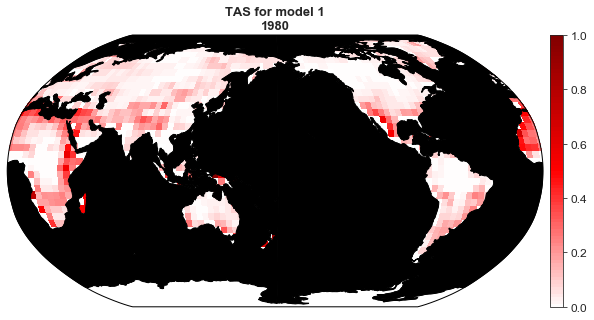

(11, 948)
Normalization: overall
(1, 948)


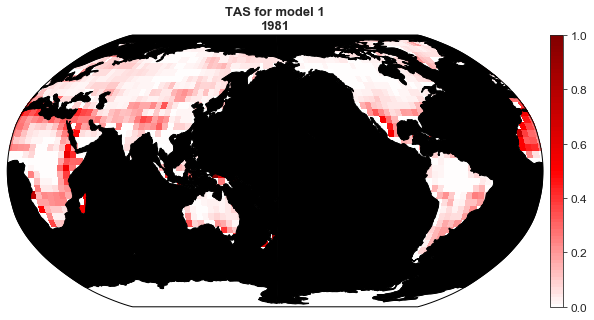

(11, 948)
Normalization: overall
(1, 948)


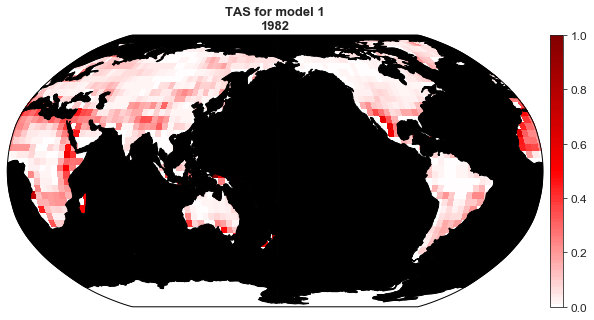

(11, 948)
Normalization: overall
(1, 948)


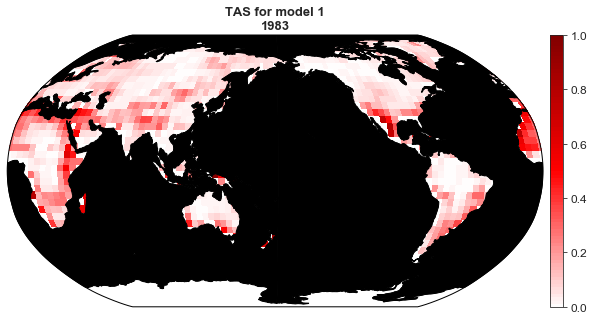

(11, 948)
Normalization: overall
(1, 948)


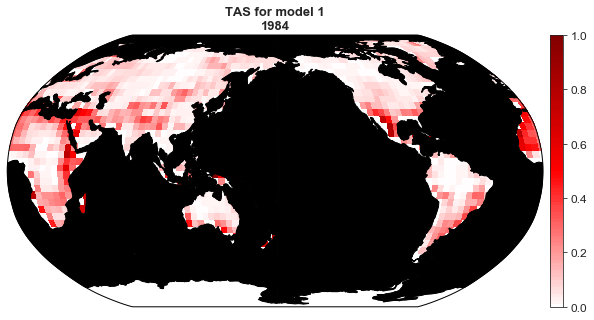

(11, 948)
Normalization: overall
(1, 948)


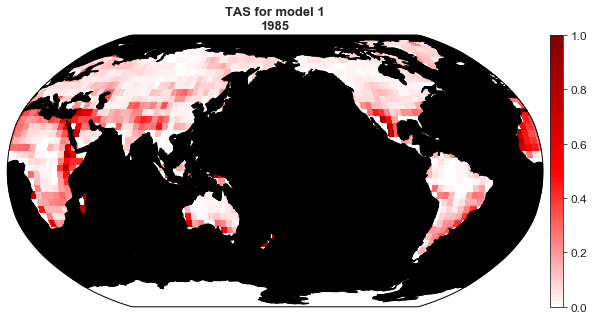

(11, 948)
Normalization: overall
(1, 948)


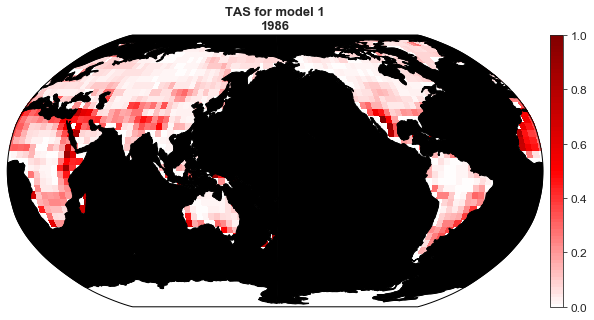

(11, 948)
Normalization: overall
(1, 948)


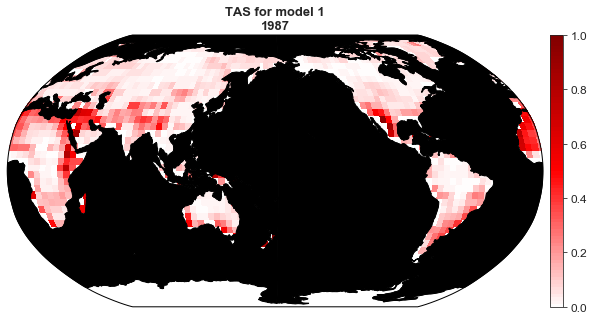

(11, 948)
Normalization: overall
(1, 948)


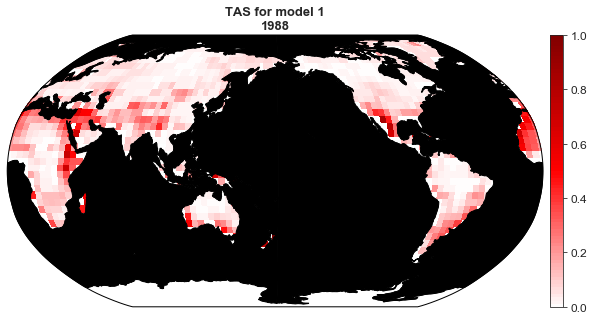

(11, 948)
Normalization: overall
(1, 948)


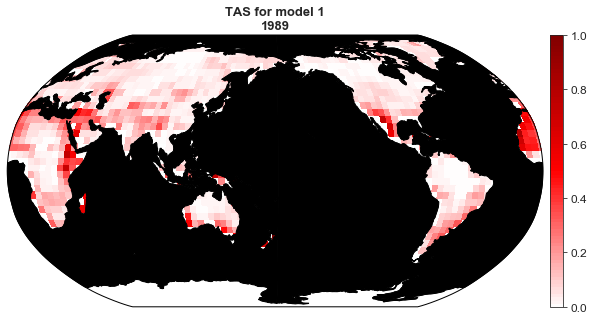

(11, 948)
Normalization: overall
(1, 948)


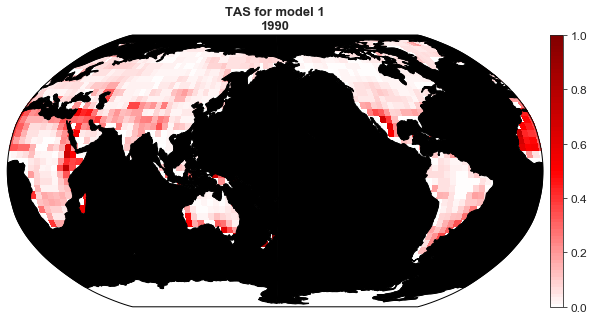

(11, 948)
Normalization: overall
(1, 948)


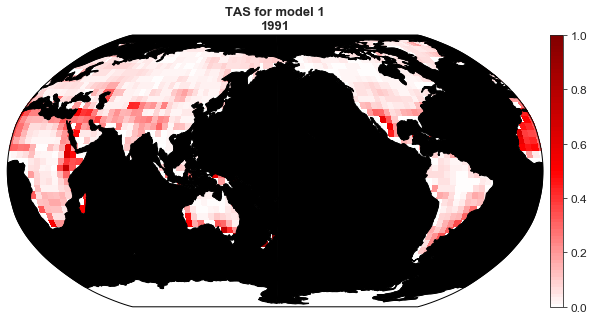

(11, 948)
Normalization: overall
(1, 948)


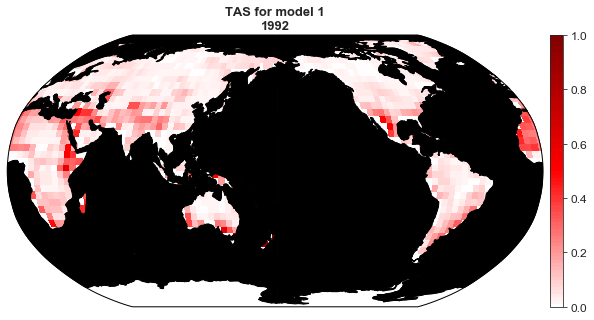

(11, 948)
Normalization: overall
(1, 948)


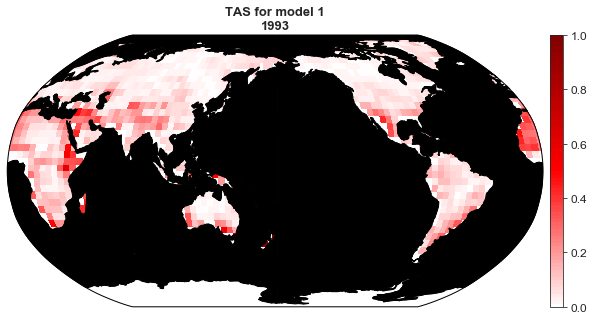

(11, 948)
Normalization: overall
(1, 948)


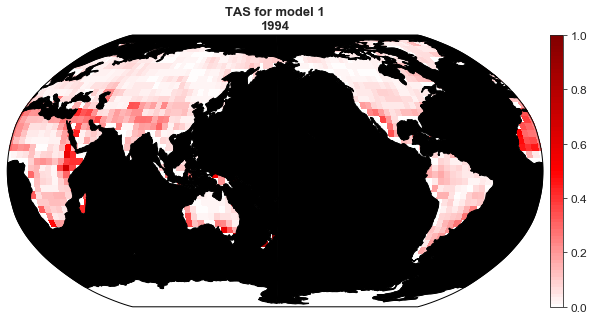

(11, 948)
Normalization: overall
(1, 948)


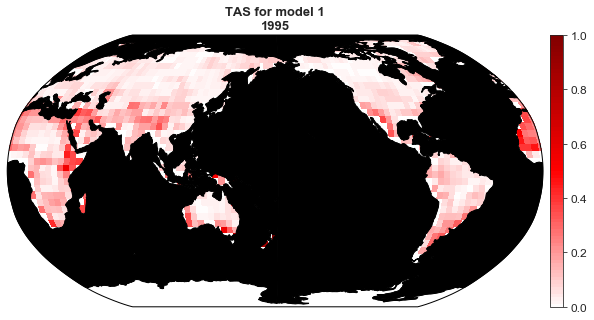

(11, 948)
Normalization: overall
(1, 948)


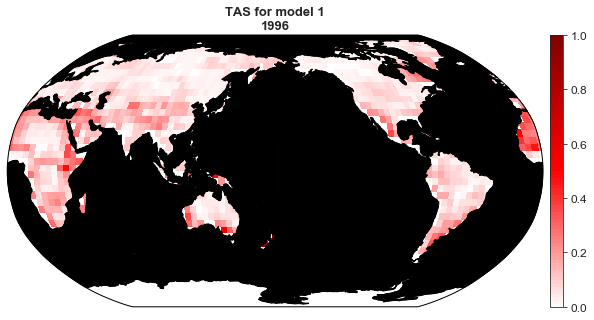

(11, 948)
Normalization: overall
(1, 948)


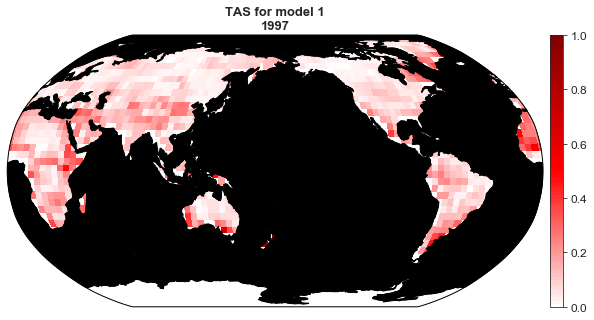

(11, 948)
Normalization: overall
(1, 948)


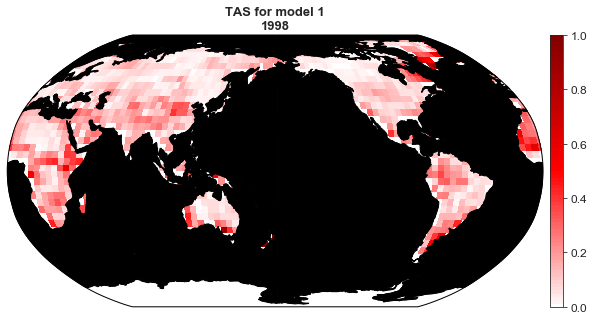

(11, 948)
Normalization: overall
(1, 948)


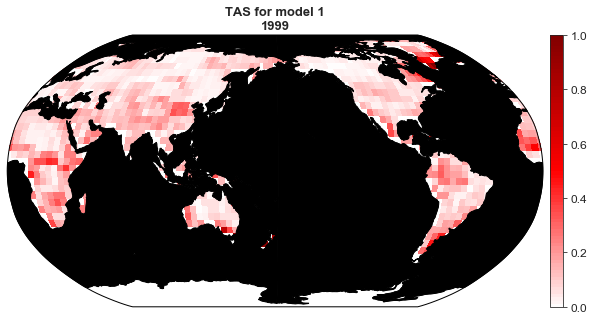

(11, 948)
Normalization: overall
(1, 948)


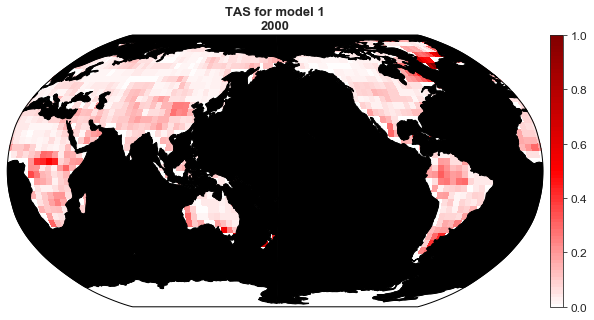

(11, 948)
Normalization: overall
(1, 948)


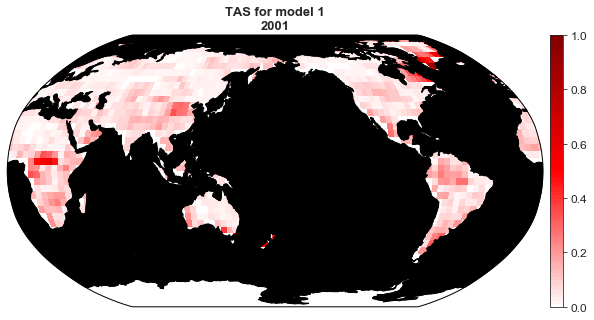

(11, 948)
Normalization: overall
(1, 948)


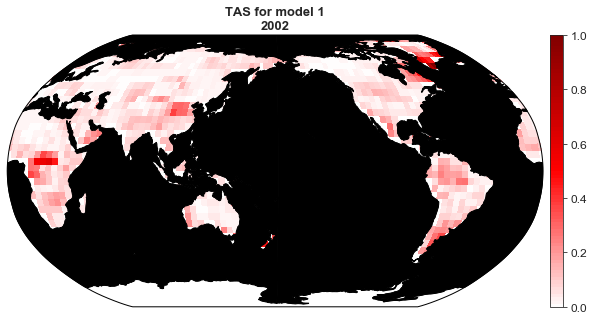

(11, 948)
Normalization: overall
(1, 948)


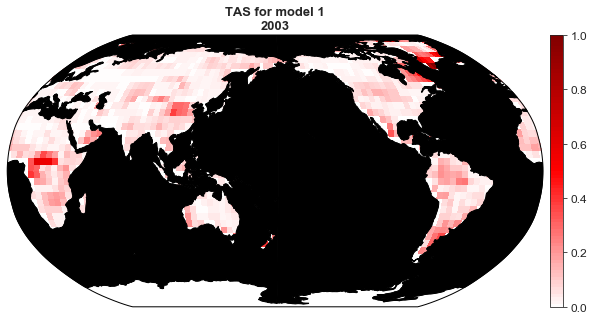

(11, 948)
Normalization: overall
(1, 948)


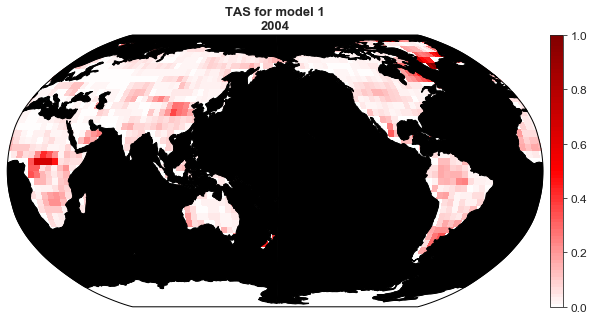

(11, 948)
Normalization: overall
(1, 948)


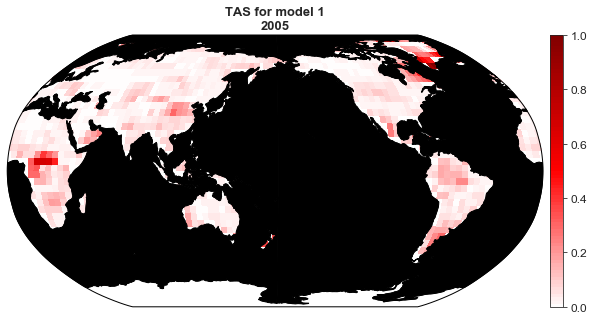

(11, 948)
Normalization: overall
(1, 948)


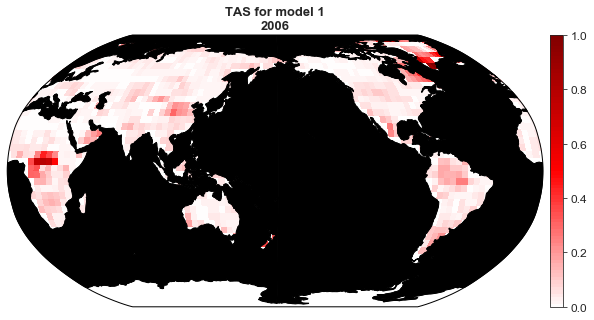

(11, 948)
Normalization: overall
(1, 948)


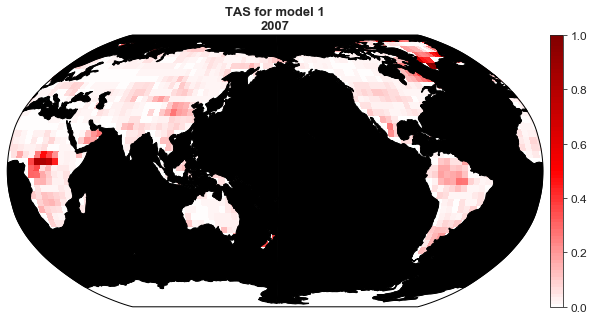

(11, 948)
Normalization: overall
(1, 948)


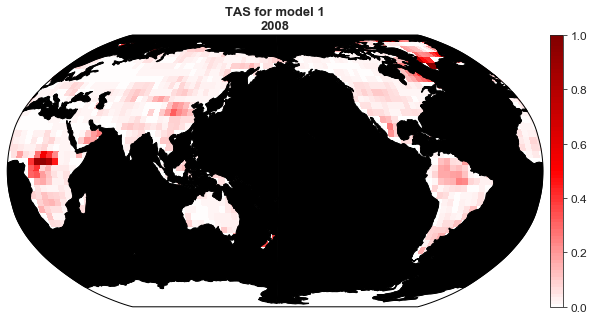

(11, 948)
Normalization: overall
(1, 948)


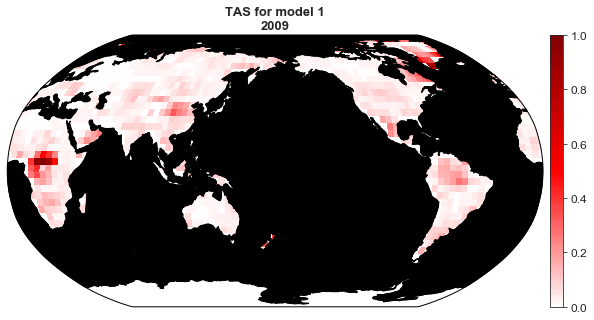

(11, 948)
Normalization: overall
(1, 948)


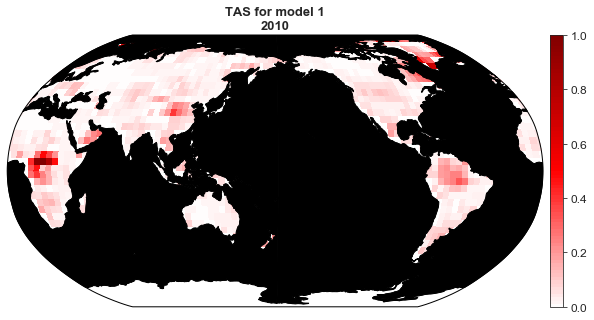

(11, 948)
Normalization: overall
(1, 948)


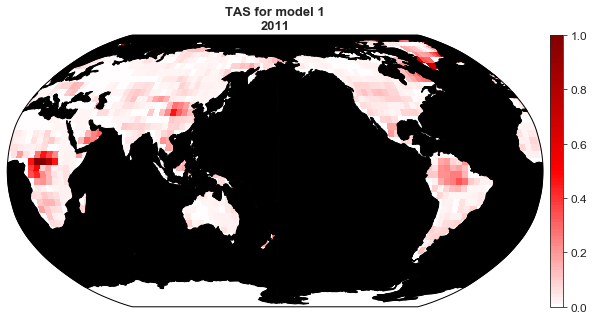

(11, 948)
Normalization: overall
(1, 948)


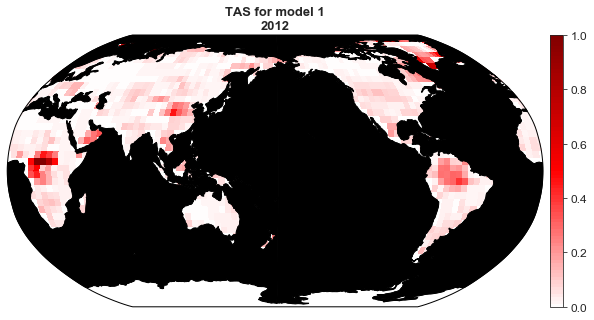

(11, 948)
Normalization: overall
(1, 948)


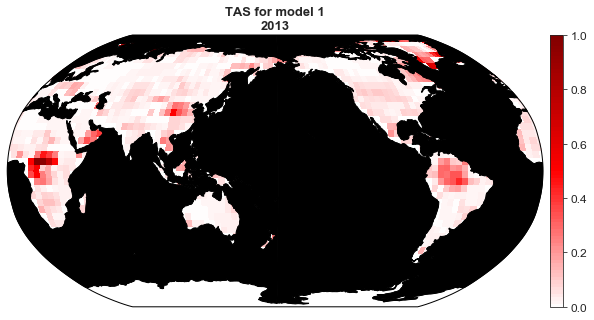

(11, 948)
Normalization: overall
(1, 948)


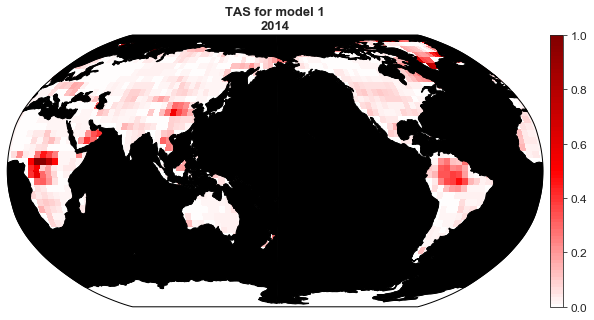

(10, 948)
Normalization: overall
(1, 948)


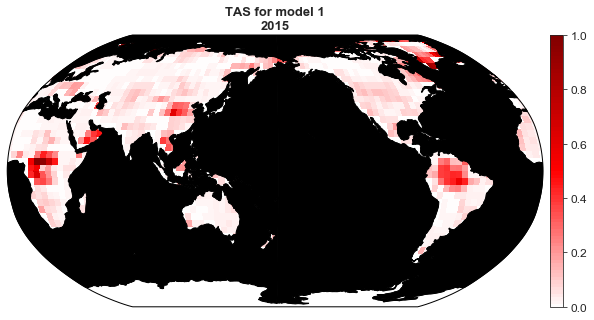

(9, 948)
Normalization: overall
(1, 948)


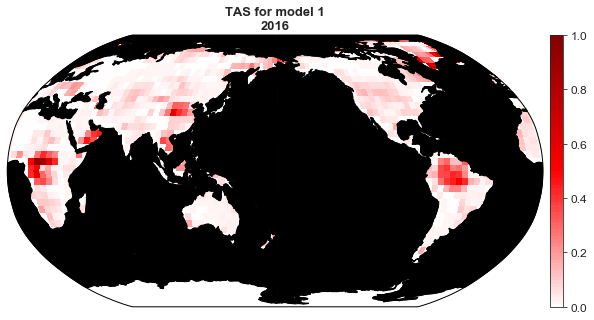

(8, 948)
Normalization: overall
(1, 948)


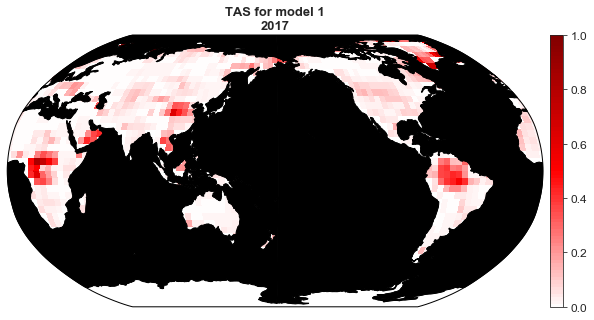

(7, 948)
Normalization: overall
(1, 948)


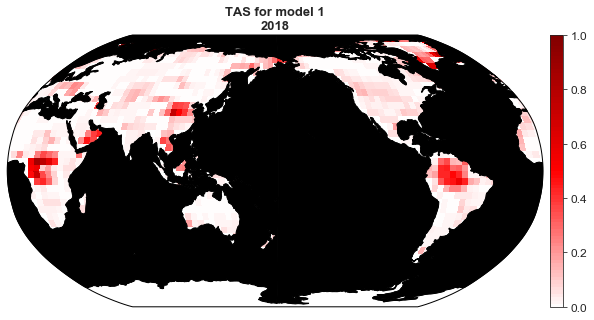

(6, 948)
Normalization: overall
(1, 948)


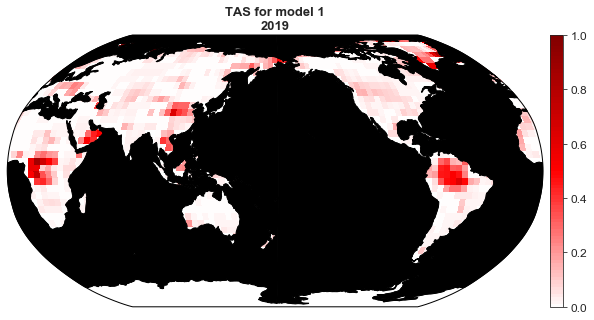

In [18]:
SAVEPLOT = False

datatype = 'obs' #model or obs
lrptype = '1yr'
#lrptype='2020-2099'
yrs = [1995, 2015, 2035, 2055, 2075, 2095]# for any single year lrp map
yrs = [2015, 2035, 2055]
yrs = np.arange(1980,2020)
#yrs = [2035]
#yrs = [1980, 1985, 1990, 1995, 2000, 2005]
mod = [False, 5] # first, if you want to use just one model, second, which model

# Load Neural Network instead of Training
model, specs_dict = load_model(update_globals = True)
model = innvestigate.utils.model_wo_softmax(model)
data, obs, years, obs_years, lats, lons, pred_years = get_lrp_data()

# For kicks, adding random data
if False:
    randdata = np.random.standard_normal(data.shape)
    randdata = np.ones(data.shape) *2
    data = randdata

#data = np.reshape(data, (np.prod(np.shape(data)[0:-1]), np.shape(data)[-1]))
#years = years.flatten()

# If doing LRP only for a single model
if datatype == 'obs':
    data = obs.copy()
    pred_years = obs_years.copy()
    years = obs_years.copy()
elif mod[0]:
    data = data[mod[1],:]
    years = years[mod[1],:]
    pred_years = pred_years[mod[1], :]

# Flatten the arrays
data = np.reshape(data, (-1, np.shape(data)[-1]))
years = years.flatten()
pred_years = pred_years.flatten()

if lrptype == 'all':
    lrpdata = data.copy()
    identifier = lrptype
    print(np.shape(lrpdata))
    plot_LRP_maps(model, lrpdata, lats, lons, identifier)
elif lrptype == '1yr':
    for yr in yrs:
        lrpdata = data[np.logical_and(np.abs(years - yr) <= 5, np.abs(years-pred_years) <= 5), :]
        #print(years[np.logical_and(np.abs(years - yr) <= 5, np.abs(years-pred_years) <= 5)])
        #print(pred_years[np.logical_and(np.abs(years - yr) <= 5, np.abs(years-pred_years) <= 5)])
        identifier = str(yr)
        print(np.shape(lrpdata))
        plot_LRP_maps(model, lrpdata, lats, lons, identifier, specs_dict)
elif lrptype == '20yr':
    for yr in np.arange(1980, 2099, 20):
        lrpdata = data[np.logical_and(years >= yr, years <= yr+20), :]
        identifier = str(yr) + '-' + str(yr+20)
        print(np.shape(lrpdata))
        plot_LRP_maps(model, lrpdata, lats, lons, identifier)
elif lrptype == '2020-2099':
    lrpdata = data[np.logical_and(years >= 2020, np.abs(years-pred_years) <= 5), :]
    identifier = lrptype
    print(np.shape(lrpdata))
    plot_LRP_maps(model, lrpdata, lats, lons, identifier)

In [8]:
MODEL_NUM

In [105]:
model, specs_dict = load_model(update_globals = True)
model = innvestigate.utils.model_wo_softmax(model)
model.predict(data[years == 2035])

array([[-19.02925  , -33.54746  , -27.187716 , -21.253849 , -14.583503 ,
         -6.549755 ,  -3.543477 ,  -3.1385074,  -4.302511 ,  -6.908722 ,
        -10.720148 , -16.458847 , -22.915785 , -28.122759 , -31.434408 ,
        -18.963102 ],
       [-17.30697  , -41.750053 , -35.15527  , -29.325716 , -21.989103 ,
        -11.010093 ,  -5.7543645,  -3.3397493,  -2.5919867,  -3.215652 ,
         -5.026198 ,  -8.444678 , -12.783926 , -16.76042  , -19.827446 ,
        -16.879885 ],
       [-16.516111 , -34.17022  , -28.171505 , -22.664644 , -16.104967 ,
         -7.5592775,  -3.9900856,  -2.7728431,  -2.980928 ,  -4.4578023,
         -7.0473614, -11.283407 , -16.334457 , -20.71667  , -23.811407 ,
        -16.323418 ],
       [-14.2115755, -27.631289 , -22.617266 , -18.079967 , -12.766845 ,
         -5.9595337,  -3.1606245,  -2.3451416,  -2.788022 ,  -4.3184576,
         -6.778698 , -10.684656 , -15.223771 , -19.072157 , -21.637842 ,
        -14.07785  ],
       [-15.229019 , -10.553246 ,  -

# Doing LRP for the 100-model experiments, and averaging the results

In [ ]:
ROOT = '/Users/jrader/Rams/TOE_Research/'
EXPERIMENT_NAME = 'pr_tas_final_globe-land/'
MODEL_SET = 'pr_tas-seas-met_models/'
STAND_TYPE = 'classification_topmodels/'
PLOT_DIR = 'plots/' + STAND_TYPE + 'lrp/' + EXPERIMENT_NAME + MODEL_SET
MODEL_NUM = MODEL_SET[:-1]
VAR = sorted(['pr-djf','pr-mam', 'pr-jja', 'pr-son', 'tas-djf','tas-mam', 'tas-jja', 'tas-son'])
RES = 'r90x45'
MASK = PATH + 'landmask/landmask_nopole_' + RES + '.npz'

TOPNUM = 100 # Number of top performing models to take 

In [ ]:
datatype = 'model' #model or obs
lrptype = '1yr_multiple'
yrs = [1980,2020,2060] #np.arange(1960,2100,10)# for any single year lrp map
yrs = [2090]
mod = [False, 5] # first, if you want to use just one model, second, which model


if lrptype == '1yr_multiple':
    
    # Opening the list of models ranked from best to worst
    f = open(ROOT + '/playground_data/' + EXPERIMENT_NAME + 'ranked_best_models/' + MODEL_SET[:-1] + '.p', 'rb')
    modelranking = pickle.load(f)
    f.close()
    
    maps_by_year = dict()
    for yr in yrs:
        maps_by_year[yr] = []
    
    for modnum in modelranking[:TOPNUM]:
        fn = ROOT + 'playground_data/' + EXPERIMENT_NAME + MODEL_SET + 'model.%03i.h5' % modnum
        print('model.%03i.h5:' % modnum, end = ' ')
        model = load_model(update_globals = True, filename = fn)
        model = innvestigate.utils.model_wo_softmax(model)
        modsetshort = MODEL_SET.split('_models')[0]
        fn = ROOT + 'data/lrp_npz_' + RES + '/' + STAND_TYPE + EXPERIMENT_NAME + 'lrp_' + modsetshort + '.npz'
        data, obs, years, obs_years, lats, lons, __ = get_lrp_data(filename=fn)
        fn2 = ROOT + 'data/lrp_npz_' + RES + '/' + STAND_TYPE + EXPERIMENT_NAME + 'predyears/predyears_' + \
            modsetshort + '_%03d.npy' % modnum
        pred_years = np.load(fn2)
        
        for yr in yrs:
            print(yr, end=' ')
            lrp_data = data[np.abs(years - yr) <= 10, :]
            lrp_output = LRP(model, lrp_data, lats, lons)
            maps_by_year[yr].append(lrp_output)
        print('', end = '     ')
        
    # ordered as 1960-var1 1960-var2 1970-var1 1970-var2 and so on ...
    allmaps = np.stack([np.stack(maps_by_year[yr]) for yr in yrs]) 
    finalmaps = np.mean(allmaps, axis = 1) # Take mean across the top 20 models
        
        
        
    # Flatten the arrays
    #data, years, pred_years = np.stack(all_data), np.stack(all_years), np.stack(all_pred_years)
    #data = np.reshape(data, (-1, np.shape(data)[-1]))
    #years = years.flatten()
    #pred_years = pred_years.flatten()

    #lrp_output_list = []
    
    #for yr in yrs:
    #    lrp_data = data[np.logical_and(np.abs(years - yr) <= 5, np.abs(years-pred_years) <= 5), :]
    #    lrp_output_list.append(LRP(model, lrp_data, lats, lons))
        
    #    identifier = str(yr) + '_obsworst'
    #    print(np.shape(lrpdata))
    #    plot_LRP_maps(model, lrpdata, lats, lons, identifier, dict())



### This will plot the average LRP map over all the TOPNUM models

0 2090 pr-djf
1 2090 pr-jja
2 2090 pr-mam
3 2090 pr-son
4 2090 tas-djf
5 2090 tas-jja
6 2090 tas-mam
7 2090 tas-son


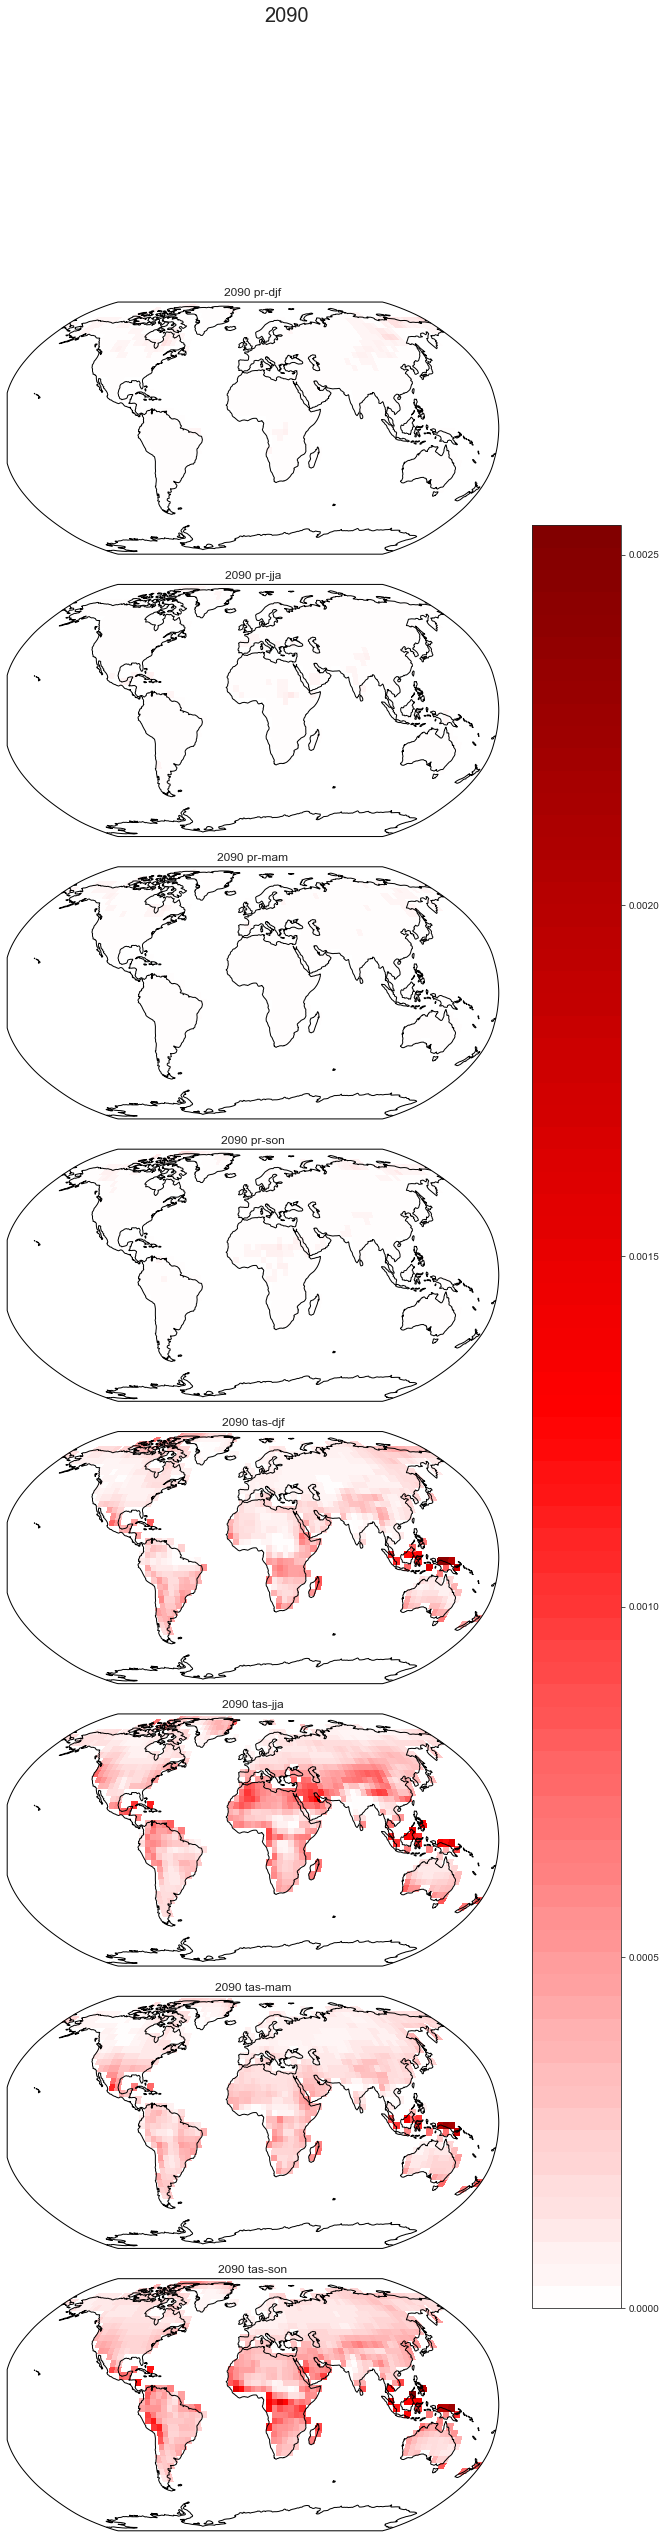

In [7]:
# allmaps has shape YEARS x TOPNUM x VAR x (latxlon, masked)
# finalmaps has shape YEARS x VAR x (latxlon, masked)
finalmaps = np.mean(allmaps, axis = 1).reshape(-1, allmaps.shape[-1]) # Take mean across the top 20 models
identifier = '_'.join([str(yr) for yr in yrs])
titles = [str(g)+' '+h for g,h in zip(sorted(yrs*len(VAR)), VAR*len(yrs))]
plot(finalmaps, lats, lons, identifier, titles = titles, ncols=4, saveplot = False, savedata=True, zoom=True)


# Clustering LRP maps for every single model (TOE and End of Century)

In [4]:
ROOT = '/Users/jrader/Rams/TOE_Research/'
ROOT = '/Users/Jamin/Google Drive/My Drive/TOE_Research/'
TRIALTYPE = '_americas-land'
EXPERIMENT_NAME = 'r95p_final' + TRIALTYPE + '/'
MODEL_SET = 'r95p-seas-met_models/'
STAND_TYPE = 'classification_topmodels/'
PLOT_DIR = 'plots/' + STAND_TYPE + 'lrp/' + EXPERIMENT_NAME + MODEL_SET
MODEL_NUM = MODEL_SET[:-1]
VAR = sorted(['r95p-djf', 'r95p-mam', 'r95p-jja', 'r95p-son'])
RES = 'r240x120'
MASK = PATH + 'landmask/landmask_nopole_' + RES + '.npz'

TOPNUM = 100 # Number of top performing models to take 
NUMBER_OF_GCMS = 32
NUMBER_OF_YEARS = 179

In [5]:
SAVEPLOT = False

datatype = 'model' #model or obs
lrptype = '1yr_multiple'
yrs = [1980,2020,2060] #np.arange(1960,2100,10)# for any single year lrp map
yrs = ['toe',2090]
yrs = [2090]
#yrs = [2090]

gcm_num_labels = np.stack([np.arange(NUMBER_OF_GCMS)]*NUMBER_OF_YEARS, axis=1)
gcm_nums = dict()
toe_nums = dict()

toe_labels = []

#OPening the dictionary with all the stats
f = open(ROOT + '/playground_data/' + EXPERIMENT_NAME+
     'bestmodeldictionary_cmip6_classification'+TRIALTYPE+'.p', 'rb')
modelstats = pickle.load(f)
f.close()
current_dictionary = modelstats[str(VAR)]
    
# Opening the list of models ranked from best to worst
f = open(ROOT + '/playground_data/' + EXPERIMENT_NAME + 'ranked_best_models/' + MODEL_SET[:-1] + '.p', 'rb')
modelranking = pickle.load(f)
f.close()
    
for modnum in modelranking[:TOPNUM]:
    starter_order = np.arange(NUMBER_OF_GCMS)
    val_ids = np.array(current_dictionary[modnum]['dataset info']['validation model id numbers'])
    final_order = np.append(np.delete(starter_order, val_ids), val_ids).tolist()
    this_ann_toes = current_dictionary[modnum]['model result']['TOE(train)'].tolist()
    val_toes = current_dictionary[modnum]['model result']['TOE(val)']
    this_ann_toes.extend(val_toes)
    this_ann_toes = [x for _,x in sorted(zip(final_order,this_ann_toes))]
    toe_labels.append(this_ann_toes)
    
toe_labels = np.stack([np.array(toe_labels)]*NUMBER_OF_YEARS, axis=-1)
print(toe_labels.shape)

if lrptype == '1yr_multiple':
    
    maps_by_year = dict()

    for yr in yrs:
        maps_by_year[yr] = []
        gcm_nums[yr] = []
        toe_nums[yr] = []
    
    for modnum in modelranking[:TOPNUM]:
        fn = ROOT + 'playground_data/' + EXPERIMENT_NAME + MODEL_SET + 'model.%03i.h5' % modnum
        print('model.%03i.h5:' % modnum, end = ' ')
        model = load_model(update_globals = True, filename = fn)
        model = innvestigate.utils.model_wo_softmax(model)
        
        modsetshort = MODEL_SET.split('_models')[0]
        fn = ROOT + 'data/lrp_npz_' + RES + '/' + STAND_TYPE + EXPERIMENT_NAME + 'lrp_' + modsetshort + '.npz'
        data, obs, years, obs_years, lats, lons, __ = get_lrp_data(filename=fn)
        # Need to calculate pred_years separately because it's not the same between LRP filenames
        fn2 = ROOT + 'data/lrp_npz_' + RES + '/' + STAND_TYPE + EXPERIMENT_NAME + 'predyears/predyears_' + \
                    modsetshort + '_%03d.npy' % modnum
        pred_years = np.load(fn2)
        
        for yr in yrs:
            print(yr, end = ' ')
            if yr == 'toe':
                yearlogic = years == toe_labels[modnum]
            else:
                yearlogic = years == yr
            lrp_data = data[yearlogic, :]
            gcm_nums[yr].append(gcm_num_labels[yearlogic])
            toe_nums[yr].append(toe_labels[modnum, yearlogic])
            lrp_output = LRP(model, lrp_data, lats, lons, timemean=False)
            ## Just taking the pr portion:
            #lrp_output = lrp_output[:,:lrp_output.shape[-1]//2]
            maps_by_year[yr].append(lrp_output)
        print('', end = '     ')
        
    # ordered as 1960-var1 1960-var2 1970-var1 1970-var2 and so on ...
    allmaps = [np.concatenate(maps_by_year[yr]) for yr in yrs]       

(100, 32, 179)
model.080.h5: WARNING:tensorflow:From /Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


/Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


2090 WARNING:tensorflow:From /Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
     model.062.h5: 2090      model.086.h5: 2090      model.081.h5: 2090      model.064.h5: 2090      model.059.h5: 2090      model.061.h5: 2090      model.072.h5: 2090      model.038.h5: 2090      model.091.h5: 2090      model.036.h5: 2090      model.047.h5: 2090      model.021.h5: 2090      model.025.h5: 2090      model.031.h5: 2090      model.027.h5: 2090      model.026.h5: 2090      model.003.h5: 2090      model.022.h5: 2090      model.014.h5: 2090      model.095.h5: 2090      model.076.h5: 2090      model.018.h5: 2090      model.029.h5: 2090      model.006.h5: 2090      model.040.h5: 2090      model.035.h5: 2090      model.033.h5:

TypeError: Unexpected keyword argument passed to optimizer: name

In [71]:
#timecode, timenum, n_clusters = 'toe', 0, 2
timecode, timenum, n_clusters = 2090, 1, 3
#timecode, timenum, n_clusters = 'toe', 0, 1
#timecode, timenum, n_clusters = 2090, 1, 32

In [8]:
model = load_model(update_globals = True, filename = '/Users/Jamin/Google Drive/My Drive/TOE_Research/playground_data/r95p_final_americas-land/r95p-seas-met_models/model.097.h5')

In [72]:
# Changing to boolean, 1 if greater than 
kmeans_to_cluster = (allmaps[timenum].T >  np.mean(allmaps[timenum], axis=(-2, -1)).T).astype(int).T
#plot(np.mean(kmeans_to_cluster, axis=0).reshape(4, -1), lats, lons, identifier = "map")
#plot(kmeans_to_cluster[0].reshape(4, -1), lats, lons, identifier = "map")


In [73]:
kmeans = KMeans(n_clusters=n_clusters, n_init = 100).fit(kmeans_to_cluster)
result = kmeans.predict(kmeans_to_cluster)
clusters, counts = np.unique(result, return_counts = True)
print(counts)

[2000  200 1000]


(4, 2314)
0 1 2 3 (4, 2314)
0 1 2 3 (4, 2314)
0 1 2 3 0 1 2 3 

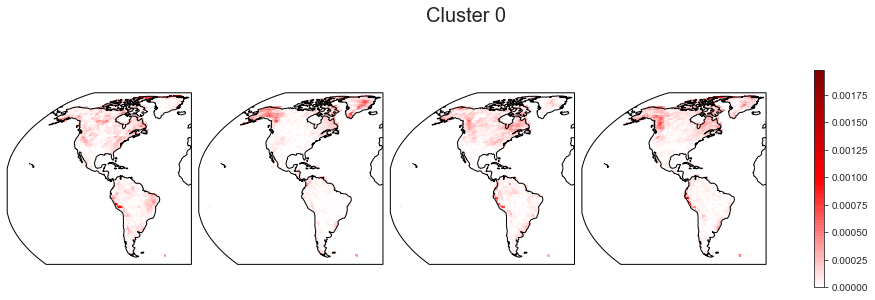

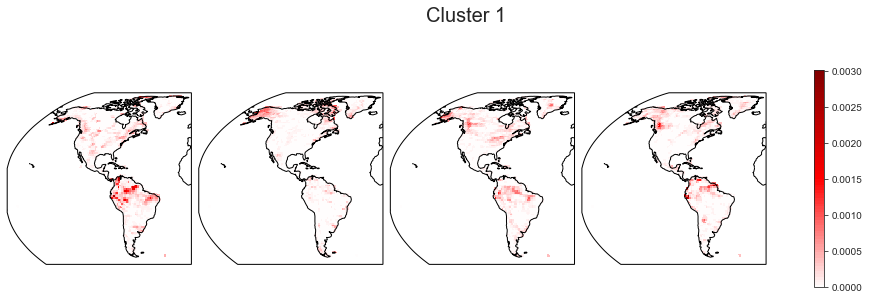

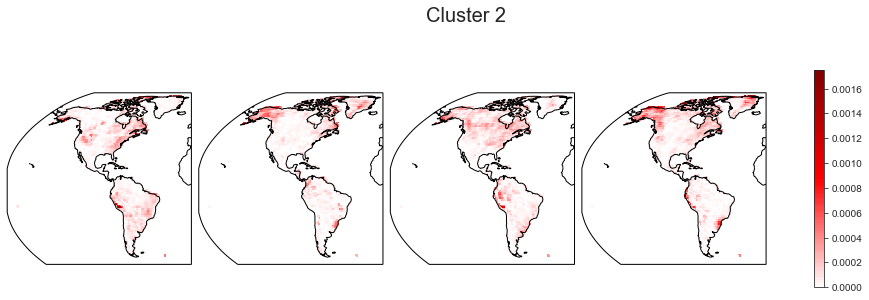

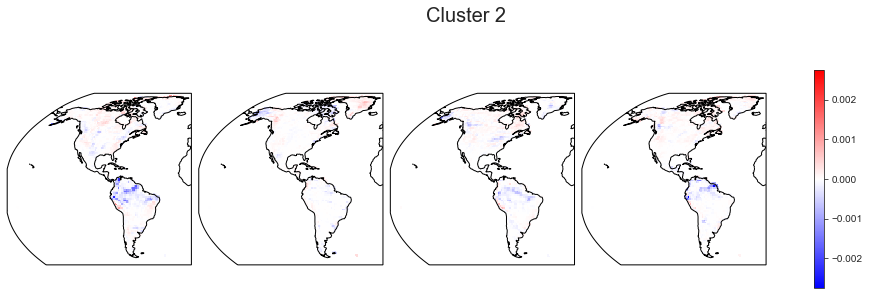

In [74]:
for clusteri in clusters:
    plottable_data = np.mean(allmaps[timenum][result == clusteri, :], axis = 0).reshape(len(VAR),-1)
    print(plottable_data.shape)
    plot(plottable_data, lats, lons, "Cluster " + str(clusteri), ncols=4, saveplot = False, savedata=False)
plottable_data = [np.mean(allmaps[timenum][result == 1, :], axis = 0).reshape(len(VAR),-1),
                  np.mean(allmaps[timenum][result == 0, :], axis = 0).reshape(len(VAR),-1)]
plot_diff(plottable_data[1], plottable_data[0], lats, lons, "Cluster " + str(clusteri), ncols=4, saveplot = False, savedata=False)
    

{'whiskers': [<matplotlib.lines.Line2D at 0x1b0af5190>,
 'caps': [<matplotlib.lines.Line2D at 0x1b0b08a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b0b02350>,
 'medians': [<matplotlib.lines.Line2D at 0x1b0989510>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b0989a10>,
 'means': []}

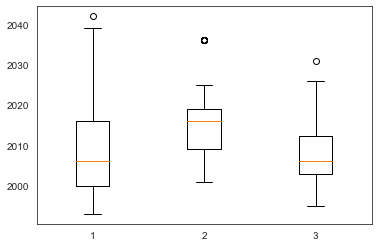

In [75]:
flat_toe = np.concatenate(toe_nums[timecode])
clustered_toe = []
for clusteri in clusters:
    clustered_toe.append(flat_toe[result == clusteri])
plt.boxplot(clustered_toe)

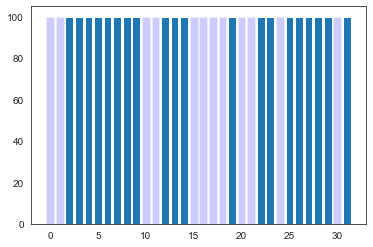

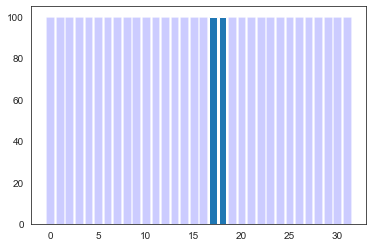

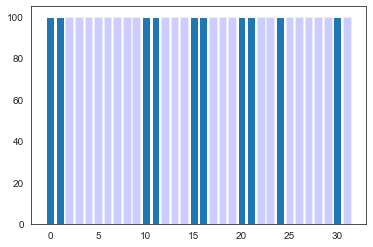

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Score (to maximize):  1.0
Number that fit: 32


In [76]:
bargraphxtot, bargraphytot = \
    np.unique(np.concatenate(gcm_nums[timecode]), return_counts = True)
for clusteri in clusters:
    bargraphx, bargraphy = np.unique(np.concatenate(gcm_nums[timecode])[result == clusteri], return_counts = True)
    plt.bar(bargraphxtot, bargraphytot, alpha=.2, color = 'blue')
    plt.bar(bargraphx, bargraphy)
    plt.show()
# Score is the square of the % of models in each group
score_list = np.array([0.]*NUMBER_OF_GCMS)
#for i, cc in np.unique(np.concatenate(gcm_nums[2090]), return_counts = True):
#    score_sum = []
#    for clusteri in clusters:
#        uniques, cc_compare = np.unique(np.concatenate(gcm_nums[2090])[result == clusteri], return_counts = True)
#        score_sum.append(cc_compare[uniques == clusteri])
all_gcm_nums, all_gcm_counts = np.unique(np.concatenate(gcm_nums[timecode]), return_counts = True)
for clusteri in clusters:
    score_numerator = np.array([0.]*NUMBER_OF_GCMS)
    these_gcm_nums, these_gcm_counts = \
        np.unique(np.concatenate(gcm_nums[timecode])[result == clusteri], return_counts = True)
    score_numerator[these_gcm_nums] = these_gcm_counts
    score_list += (score_numerator / all_gcm_counts)**2
score_list = (score_list - 1 / len(clusters)) / (1 - 1 / len(clusters))
print(score_list)

print('Score (to maximize): ', (np.mean(score_list)))
print('Number that fit:', len(score_list[score_list > .5]))

In [77]:
flat_toe = np.concatenate(toe_nums[timecode])

relevancedata = []
bargraphxdata = []
bargraphydata = []
toeboxdata = []


for clusteri in clusters:
    plottable_data = np.mean(allmaps[timenum][result == clusteri, :], axis = 0).reshape(len(VAR),-1)
    relevancedata.append(plottable_data)
    bargraphx, bargraphy = np.unique(np.concatenate(gcm_nums[timecode])[result == clusteri], return_counts = True)
    bargraphxdata.append(bargraphx)
    bargraphydata.append(bargraphy)
    toebox = flat_toe[result == clusteri]
    toeboxdata.append(toebox)
    
#kmeans_to_cluster #The actual data used to do the clustering
#result #Clustering results (0, 1)

outfilename = ROOT + 'playground_data/clusterdata/'+MODEL_SET.split('_')[0]+'_'+str(timecode)+'_'+ \
              str(n_clusters) +'clusters_data.npz'
print(outfilename)

np.savez(outfilename, 
         relevance_maps = relevancedata, bargraphx = bargraphxdata, 
         bargraphy = bargraphydata, toes = toeboxdata,
         kmeans_input = kmeans_to_cluster, kmeans_output = result, all_maps = allmaps[timenum],
         lats = lats, lons = lons, allow_pickle=True)


/Users/jrader/Rams/TOE_Research/playground_data/clusterdata/r95p-seas-met_2090_3clusters_data.npz


(4, 2314)


# Comparing relevances

In [4]:
ROOT = '/Users/Jamin/Rams/TOE_Research/'
EXPERIMENT_NAME = 'r95p_seas_americas-land/'
MODEL_SET = 'r95p-month_models/'
STAND_TYPE = 'classification_topmodels/'
PLOT_DIR = 'plots/' + STAND_TYPE + 'lrp/' + EXPERIMENT_NAME + MODEL_SET
MODEL_NUM = MODEL_SET[:-1]
VAR = np.arange(1,13)

TOPNUM = 20 # Number of top performing models to take 

In [5]:
SAVEPLOT = False

datatype = 'model' #model or obs
yrs = np.arange(1960,2100,10)# for any single year lrp map
mod = [False, 5] # first, if you want to use just one model, second, which model

    
# Opening the list of models ranked from best to worst
f = open(ROOT + '/playground_data/' + EXPERIMENT_NAME + 'ranked_best_models/' +MODEL_NUM+'.p', 'rb')
modelranking = pickle.load(f)
f.close()

for modnum in modelranking[:TOPNUM]:
    print(modnum, end=' ')
    fn = ROOT + 'playground_data/' + EXPERIMENT_NAME + MODEL_SET + 'model.%03i.h5' % modnum
    model = load_model(update_globals = True, filename = fn)
    model = innvestigate.utils.model_wo_softmax(model)
    modsetshort = MODEL_SET.split('_models')[0]
    fn = ROOT + 'data/lrp_npz_' + RES + '/' + STAND_TYPE + EXPERIMENT_NAME + 'lrp_' + modsetshort + '.npz'
    data, obs, years, obs_years, lats, lons, pred_years = get_lrp_data(filename=fn)
    all_data = []
    all_years = []
    all_pred_years = []
    # If doing LRP only for a single model
    if datatype == 'obs':
        data = obs.copy()
        pred_years = obs_years.copy()
        years = obs_years.copy()
    elif mod[0]:
        data = data[mod[1],:]
        years = years[mod[1],:]
        pred_years = pred_years[mod[1], :]

    all_data.append(data)
    all_years.append(years)
    all_pred_years.append(pred_years)

# Flatten the arrays

data, years, pred_years = np.stack(all_data), np.stack(all_years), np.stack(all_pred_years)
data = np.reshape(data, (-1, np.shape(data)[-1]))
years = years.flatten()
pred_years = pred_years.flatten()

if SAVEPLOT:
    firstdir = [i + '/' for i in PLOT_DIR.split('/')[:-2]]
    seconddir = [i + '/' for i in PLOT_DIR.split('/')[:-1]]
    os.system('mkdir ' + ROOT + ''.join(firstdir))
    os.system('mkdir ' + ROOT + ''.join(seconddir))

top = []
mid = []
bot = []


print()
for yr in yrs:
    print(yr, end=' ')
    lrpdata = data[np.logical_and(np.abs(years - yr) <= 5, np.abs(years-pred_years) <= 5), :]
    #print(years[np.logical_and(np.abs(years - yr) <= 5, np.abs(years-pred_years) <= 5)])
    #print(pred_years[np.logical_and(np.abs(years - yr) <= 5, np.abs(years-pred_years) <= 5)])
    identifier = str(yr)
    relmean, rello, relhi = return_fractional_relevance(model, lrpdata)
    top.append(relhi)
    mid.append(relmean)
    bot.append(rello)

top = np.stack(top)
mid = np.stack(mid)
bot = np.stack(bot)

64 WARNING:tensorflow:From /Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
46 57 55 15 59 87 79 84 19 65 43 4 17 48 62 35 93 94 38 (1, 32, 180, 112908) (1, 32, 180) (1, 32, 180)

(5760, 112908)


1960 WARNING:tensorflow:From /Users/Jamin/anaconda3/envs/toe1/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 

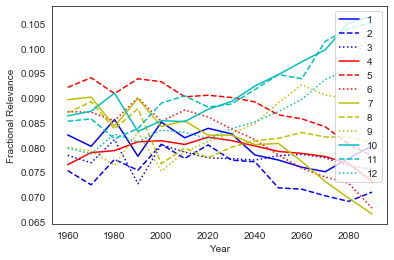

In [15]:
fmtlist = 'b,b--,b:,r,r--,r:,y,y--,y:,c,c--,c:'.split(',')
for mm, fmt in zip(mid.T, fmtlist):
    plt.plot(yrs,mm,fmt)
    plt.legend(VAR)
    plt.ylabel('Fractional Relevance')
    plt.xlabel('Year')

[[0.08486683 0.08296173 0.08441914 0.08108568]
 [0.08450644 0.08226726 0.08426535 0.08229436]
 [0.0842814  0.0846255  0.08252691 0.08189955]
 [0.08502667 0.08286552 0.08209968 0.08334149]
 [0.08451147 0.08375395 0.08456551 0.08050246]
 [0.08374661 0.08349481 0.08493075 0.08116118]
 [0.0851948  0.08476456 0.08281538 0.08055871]
 [0.08517503 0.08345968 0.08297446 0.08172417]
 [0.08415851 0.08368137 0.08322208 0.08227137]
 [0.08433639 0.08165357 0.08460449 0.0827389 ]
 [0.08479023 0.08153629 0.08319106 0.08381572]
 [0.08325805 0.08130657 0.08413462 0.08463409]
 [0.08278487 0.08231722 0.0833223  0.08490887]
 [0.08315213 0.0817213  0.0824294  0.08603042]]


# How does Validation RMSE change over time?

In [5]:
ROOT = '/Users/Jamin/Rams/TOE_Research/'
EXPERIMENT_NAME = 'r95p_seas_americas-land/'
model_set_set = ['r95p-seas-met_models/', 'r95p-seas-alt_models/', 'r95p-seas-ord_models/']
STAND_TYPE = 'classification_topmodels/'
VAR = sorted(['r95p-djf','r95p-mam','r95p-jja','r95p-son'])

TOPNUM = 20 # Number of top performing models to take 

r95p-seas-met_models/
579929112474953199793836461129875835r95p-seas-alt_models/
9957296449721967478712653939527215856r95p-seas-ord_models/
457329947641997298365924311153618727

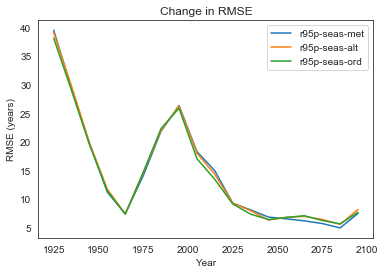

In [6]:
for MODEL_SET in model_set_set:
    print(MODEL_SET)
    datatype = 'model' #model or obs
    lrptype = '1yr_multiple'
    yrs = [1980,2020,2060] #np.arange(1960,2100,10)# for any single year lrp map
    mod = [False, 5] # first, if you want to use just one model, second, which model    

    # Opening the list of models ranked from best to worst
    f = open(ROOT + '/playground_data/' + EXPERIMENT_NAME + 'ranked_best_models/' + MODEL_SET[:-1] + '.p', 'rb')
    modelranking = pickle.load(f)
    f.close()

    all_years = []
    all_pred_years = []

    for modnum in modelranking[:TOPNUM]:
        print(modnum, end='')
        modsetshort = MODEL_SET.split('_models')[0]
        fn = ROOT + 'data/lrp_npz_' + RES + '/' + STAND_TYPE + EXPERIMENT_NAME + 'lrp_' + modsetshort + '.npz'
        data, obs, years, obs_years, lats, lons, pred_years = get_lrp_data(filename=fn)
        all_years.append(years)
        all_pred_years.append(pred_years)

    years, pred_years = np.stack(all_years), np.stack(all_pred_years)

    def rmse(predictions, targets):
        return np.sqrt(np.mean((predictions - targets) ** 2))

    y = []
    x = np.arange(1925,2100, 10)
    for yr in x:
        y.append(rmse(pred_years[abs(years-yr) < 5], years[abs(years-yr) < 5]))
    plt.plot(x,y,label=MODEL_SET[:13])
plt.ylabel('RMSE (years)')
plt.xlabel('Year')
plt.legend()
plt.title('Change in RMSE')
plt.show()
    

In [14]:
outfilename = ROOT + 'playground_data/clusterdata/r95p-seas-met_toe_' \
+ str(1) + 'clusters_data.npz'
clusterdata = np.load(outfilename, allow_pickle = True) 
relevance_maps, bargraphx, bargraphy, toes, kmeans_input, kmeans_output, lats, lons = \
    clusterdata['relevance_maps'], clusterdata['bargraphx'], clusterdata['bargraphy'], \
    clusterdata['toes'], clusterdata['kmeans_input'], clusterdata['kmeans_output'], \
    clusterdata['lats'], clusterdata['lons']

(2314,)

948